# Processor testing for first infection running

In [1]:
import os
import sys
import xarray
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import skimage as ski
from image_handling.imagej_manager import ImageJManager
from analysis_class import ImageProcessor
from image_handler_class import ImageAlignmentAndTifConversion
from key_class import Key

ij = ImageJManager('default').get_ij()

SyntaxError: non-default argument follows default argument (analysis_class.py, line 169)

In [3]:
key = Key(r'E:\Patrick\Keys\Infection_20250207.csv', ['date', None, None, None, 'well'], skip_validation=True)


aligning_class = ImageAlignmentAndTifConversion(ij=ij,  observation_methods=2, initialized_key=key, 
                                                tracker_name=r"E:\Patrick\tracking_jsons\infection_tracker.json")

aligning_class.process_images(r'E:\Patrick\Infection\New_parameters\Infection_20250207', save_dir=r'E:\Patrick\Infection\New_parameters\20250207_infection_save\Tif\\')

2025-03-14 16:17:55,303 - INFO - Tracker data saved.
2025-03-14 16:17:55,303 - INFO - Tracker has been reset.


In [3]:
aligning_class.file_tracker.tracker_data

{'all_files': [],
 'current_files': [],
 'failed_files': [],
 'pipeline_failed': False,
 'last_run': '2025-03-05 02:03:01.883433'}

In [2]:
segmenter = ImageProcessor(ij, r'E:\Patrick\Infection\New_parameters\20250207_infection_save\Tif\aligned_images\\', tracker_file='E:\Patrick\tracking_jsons\track_infection.json', dataframe_file='E:\Patrick\dataframes\20250207_infection_dataframe.pkl')

Initialized new empty DataFrame.


2025-03-14 18:36:13,383 - INFO - Loaded 384 files
2025-03-14 18:36:13,384 - ERROR - Failed to save tracker data: [Errno 22] Invalid argument: 'E:\\Patrick\tracking_jsons\track_infection.json'


In [3]:
df = segmenter.image_segmentation()

2025-03-14 23:04:54,687 - ERROR - Failed to save tracker data: [Errno 22] Invalid argument: 'E:\\Patrick\tracking_jsons\track_infection.json'
2025-03-14 23:04:54,688 - INFO - Tracker has been reset.
2025-03-14 23:04:54,689 - INFO - Progress: 0/0 files processed. 0 remaining. files failed: 0.


In [4]:
df.to_csv(r'E:\Patrick\Infection\New_parameters\20250207_infection_save\csvs\first_test.csv')

In [6]:
df.groupby(['construct', 'experimentcondition'])['donor_intensity_mean'].count()

construct  experimentcondition
1          Growth                 2712
           Infect                 2255
10         Growth                 2256
           Infect                 2239
11         Growth                 1321
           Infect                 1320
12         Growth                 3621
           Infect                 3011
2          Growth                 2342
           Infect                 2227
3          Growth                 3799
           Infect                 3263
4          Growth                 2174
           Infect                 2293
5          Growth                 2968
           Infect                 2591
6          Growth                 1397
           Infect                 1316
7          Growth                 1503
           Infect                 1751
8          Growth                 1784
           Infect                 2097
9          Growth                 1610
           Infect                 1412
GS32       Growth                

In [7]:
#calculation
def pixels_to_micron(df: pd.DataFrame, area_column: str='area', pixels_per_micron: float = 3.0769) -> pd.DataFrame:
    df= df.rename(columns={area_column: 'area_pixels'})
    df['area_micron'] = df['area_pixels']/pixels_per_micron
    return df



def acceptor_correction(df: pd.DataFrame, stat:str = 'mean', crossex_correction: float=0.068, bleedthrough_correction:float=0.47)-> pd.DataFrame:
    df['crossexcitation_correction'] = crossex_correction
    df['bleedthrough_correction'] = bleedthrough_correction
    df['acceptor_corrected_'+stat] = df['acceptor_intensity_'+stat] - df['donor_intensity_'+stat] *bleedthrough_correction - df['directAcceptor_intensity_'+stat] * crossex_correction
    return df



def calculate_efret(df: pd.DataFrame, stat: str='mean')->pd.DataFrame:
    df['Efret'] = df['acceptor_corrected_'+stat]/(df['donor_intensity_'+stat]+df['acceptor_corrected_'+stat])
    return df



def area_cutoffs(df: pd.DataFrame, area = 'area_micron', lower_cutoff:float = 600.0, upper_cutoff: float=7000)-> pd.DataFrame:
    df = df.loc[(df[area] > lower_cutoff) & (df[area] < upper_cutoff)]
    df = df.reset_index(drop=True)
    return df

def remove_maximums(df: pd.DataFrame, channel: str, value_cutoff: float = 55000)-> pd.DataFrame:
    channel_cutoff = channel+'_intensity_max'
    df = df.loc[df[channel_cutoff] < value_cutoff]
    df = df.reset_index(drop=True)
    return df 

def calculate_time(df: pd.DataFrame, experiment: str): 
    experiment_timeframe ={
        'infection' : 4,
        'osmoticperturbation' : 0.1,
        'heatshock': 0.5,
        'blasticidin': 0.5,
    }
    
    timeframe = experiment_time[experiment]
    df['time'] = df['timepoint'].astype(int) * timeframe
    return df

def remove_minimums(df: pd.DataFrame, channel: str, value_cutoff = 400)-> pd.DataFrame:
    channel_cutoff = channel+'_intensity_min'
    df = df.loc[df[channel_cutoff] > value_cutoff]
    df = df.reset_index(drop=True)
    return df

def directacceptor_mean_cutoffs(df: pd.DataFrame, lower_cutoff: float = 1000, upper_cutoff=40000) -> pd.DataFrame:
    df = df.loc[(df['directAcceptor_intensity_mean']> lower_cutoff) & (df['directAcceptor_intensity_mean'] < upper_cutoff)]
    return df


def donor_mean_cutoffs(df: pd.DataFrame, lower_cutoff: float = 700, upper_cutoff=20000) -> pd.DataFrame:
    df = df.loc[(df['donor_intensity_mean']> lower_cutoff) & (df['donor_intensity_mean'] < upper_cutoff)]
    return df

def infection_false_positives(df: pd.DataFrame) -> pd.DataFrame:
    # Define threshold conditions for each timepoint
    thresholds = {
        0: 400, 
        1: 2000, 
        2: 7000,
        3: 15000,  # Extend for other timepoints if needed
    }
    
    # Apply filtering conditionally for timepoints in the dictionary
    for time, threshold in thresholds.items():
        df = df.loc[~((df['timepoint'] == time) & (df['mCherry_intensity_mean'] > threshold))]

    df = df.reset_index(drop=True)
    return df

def infection_parameters(df: pd.DataFrame, mCherry_intensity: float = 1000.0) -> pd.DataFrame:
    df = df.copy()  # Ensure original DataFrame is not modified in place
    df['experimentparameter'] = np.where(df['mCherry_intensity_mean'] < mCherry_intensity, 'noninfected', 'infected')
    return df

def set_categorical_order(df: pd.DataFrame, column_name: str, category_order: list[str]) -> pd.DataFrame:
    df = df.copy()  # Ensure we don't modify the original DataFrame in-place

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")
    
    # Ensure existing values in the column are not lost
    existing_values = df[column_name].dropna().unique()
    
    # Combine user-defined order with existing unique values while preserving order
    complete_order = list(dict.fromkeys(category_order + list(existing_values)))  

    # Apply the categorical dtype
    cat_type = CategoricalDtype(categories=complete_order, ordered=True)
    df[column_name] = df[column_name].astype(cat_type)

    return df  # Return modified DataFrame without affecting other columns

def sort_values(df: pd.DataFrame, sort_dict: dict[str, list[str]])-> pd.DataFrame:
    tmp_df = df.copy()
    for index, sorter_values in sort_dict.items():
        new_df = set_catergorical_values(tmp_df, index, sorter_values)
    return new_df
    
def compare_deltas(df: pd.DataFrame,  group_values: list, delta_column: str) -> pd.DataFrame:
    # Ensure sorting for time-based delta calculations
    df = df.sort_values(by=group_values)

    new_grouper = group_values.remove('timepoint')
    # Compute deltas for the given column
    df[f'delta_{delta_column}'] = df.groupby(new_grouper)[delta_column].diff()
    
    return df


def get_counts(df: pd.DataFrame, group_values: list):
    #count per experiment
    #count per construct
    #count per condition
    #count per parameter
    #count per timepoint
    #count per date
    #count per well
    #count of wells
    #count per replicate
    
    tmp_counts = df.groupby(group_values)['Efret'].count()
    return tmp_counts


def get_medians(df: pd.DataFrame, group_values):
    tmp_medians = df.groupby(group_values)['Efret'].median()
    return tmp_medians    

def get_errorbars():
    return

In [9]:
import seaborn as sns

C:\Users\patri\AppData\Local\Temp\ipykernel_23388\415839755.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noninfected_only['experimentparameter'] = 'Growth'
D:\anaconda3\envs\pyimagej\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
D:\anaconda3\envs\pyimagej\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

<Axes: xlabel='construct', ylabel='Efret'>

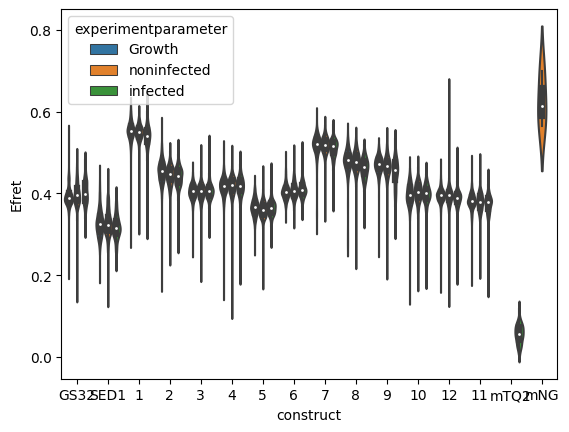

In [10]:
tmp_df = pixels_to_micron(df)
tmp_df = acceptor_correction(tmp_df)
tmp_df = calculate_efret(tmp_df)
tmp_df = area_cutoffs(tmp_df)
tmp_df = remove_maximums(tmp_df, 'directAcceptor')
tmp_df = remove_minimums(tmp_df, 'directAcceptor')
tmp_df = directacceptor_mean_cutoffs(tmp_df)
tmp_df = donor_mean_cutoffs(tmp_df)

tmp_df = infection_false_positives(tmp_df)

tmp_df = infection_parameters(tmp_df)



construct_order = ['GS32', 'SED1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12']
experiment_order = ['Infection']
experiment_condition = ['Growth', 'Infect']
experiment_parameter = ['noninfected', 'infected']

my_sort_dict = {
            'construct' : construct_order,
            'experiment': experiment_order,
            'experimentcondition': experiment_condition,
            'experimentparameter': experiment_parameter, 
               }




tmp_df = set_categorical_order(tmp_df, column_name='construct', category_order= construct_order)

growth_df = tmp_df.loc[tmp_df['experimentcondition'] == 'Growth']
noninfected_only = growth_df.loc[growth_df['experimentparameter'] == 'noninfected']
noninfected_only['experimentparameter'] = 'Growth'


this_df = tmp_df.loc[tmp_df['experimentcondition'] == 'Infect']

test_df = pd.concat([noninfected_only, this_df])
sns.violinplot(test_df, x='construct', y='Efret', hue='experimentparameter')



In [166]:
this_df = get_count(tmp_df, [''])
print(this_df)

Series([], Name: construct, dtype: category
Categories (13, object): ['GS32', 'SED1', '1', '2', ..., '8', '9', '10', '12'])

In [ ]:
img= img.transpose('t', 'ch', 'row', 'col' )
java_img = ij.py.to_java(img)
java_img.shape


In [25]:
ij.IJ.save(java_img, r'E:\test.tif')

In [25]:
img =ij.io().open(r'E:\Patrick\Infection\New_parameters\20250207_infection_save\Tif\aligned_images\date-20250209_techReplicate-1_well-A5_construct-1_experiment-Infection_experimentcondition-Infect_replicate-2_passages-26_exposurecam1-25_cyanled-12u5_exposurecam2-25_blueled-12u5_greenled-6u5.tif')
print(img.shape)
img = ij.py.from_java(img)
print(img.sizes)

(2048, 2048, 4, 9)
Frozen({'t': 9, 'row': 2048, 'col': 2048, 'ch': 4})


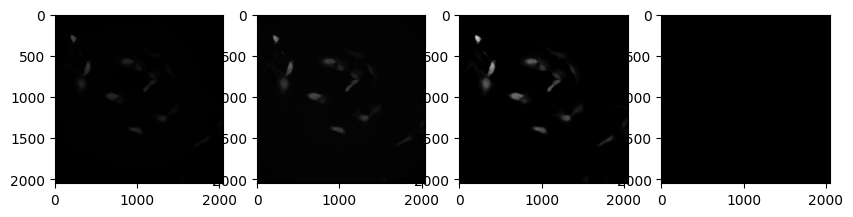

In [31]:
tmp_img = img.isel(t=0)
fig, ax = plt.subplots(1, 4, figsize=(10,10))
for i in range(tmp_img.sizes['ch']):
    ax[i].imshow(tmp_img.isel(ch=i), cmap='gray', vmin= 150, vmax=25000)
    

In [ ]:
class DataCleaner:
    def __init__(self, df):
        self.dataframe = df
        self.cleaned_df = 
        
        self.plotting_Storage = PlottingStorage()
        self.plotting_storage.experiment_dict = self.__get_unique_experiments()
        self.plotting_storage.timepoint_dict  = self.__get_timepoints() 

    
    def __get_unique_experiments(self)-> dict:
        unique_experiments = self.dataframe.experiment.unique()
        return {index: unique_experiment[index] for index in range(len(unique_experiment))}

    def __get_unique_experiment_time(self, experiment)-> dict:
        tmp_df = self.dataframe.loc[self.dataframe['experiment'] == experiment]
        unique_timepoint = tmp_df.timepoint.unique()
        return {index: unique_experiment[index] for index in range(len(unique_timepoint))}

    def __get_timepoints(self):
        return {self.plotting_storage.experiment_dict[index]: self.__get_unique_experiment_time(self.plotting_storage.experiment_dict[index]) for index in range(len(self.plotting_storage.experiment_dict[index]))}

    def __get_(self):

    def __clean_df(self):
        